In this work, you are required to train a model for dataset MNIST with PyTorch.

Load dataset:

In [2]:
#need to set three item on GPU, such as the dataset (data and target), model, loss function  

In [3]:
import torchvision
from torchaudio import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
#define the equipment to train
device = torch.device("cuda")

#load the dataset of mnist
train_data = MNIST(
    root = "data",
    download = True,
    train = True,
    transform = torchvision.transforms.ToTensor()
    )
test_data = MNIST(
    root = "data",
    download = True,
    train = False,
    transform = torchvision.transforms.ToTensor()
    )

train_dataloader = DataLoader(train_data, batch_size = 64)
test_dataloader = DataLoader(test_data, batch_size = 64)

In [4]:
#check the dimension
examples = enumerate(train_dataloader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_targets)
print(example_data.shape)

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
        9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0])
torch.Size([64, 1, 28, 28])


C:\Users\13463666296\AppData\Local\Temp\ipykernel_29784\2119449247.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout() #自动检查子图的坐标轴，标题和刻度标签


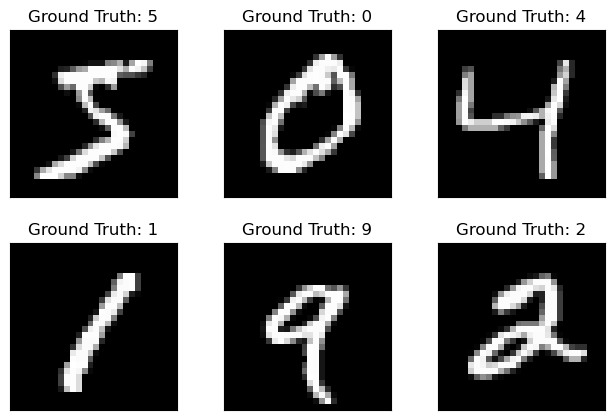

In [5]:
#show some images of mnist
import matplotlib.pyplot as plt
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout() #自动检查子图的坐标轴，标题和刻度标签
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()

Model: you may select your favorite model and implement it in the following class.

In [6]:
#define the network: the convolution and pool in the Convolution neural network should satisfy the computing rules, such the dimension of the H_out. The method of calculating is described in the doc of torch.       
class Model(nn.Module):
  # Your code here
  def __init__(self):
      super(Model,self).__init__()
      #CIFAR 10 model
      self.model = nn.Sequential(
          nn.Conv2d(1,32,5,1,2),
          nn.MaxPool2d(2),
          nn.Conv2d(32,64,5,1,2),
          nn.MaxPool2d(2),
          nn.Flatten(),
          nn.Linear(64*7*7,64),
          nn.Linear(64,10)
      )
  def forward(self,x):
      #img-->feature-->score_classes
      x = self.model(x)
      return x

  # End code here

In [7]:
# give an example
model = Model()
input = torch.ones((1,1,28,28))
output = model(input)     
print(output,output.shape)


tensor([[ 0.1233,  0.0553,  0.0785, -0.0748,  0.0280, -0.0241, -0.0611, -0.0688,
          0.1152,  0.0015]], grad_fn=<AddmmBackward0>) torch.Size([1, 10])


Evaluation: you need to implement a pipeline to train your neural network.

In [12]:
# train and test on CPU
from torch.utils.tensorboard import SummaryWriter
model = Model()
# 1. put the model on GPU
model = model.to(device) # method 1
# if torch.cuda.is_available(): # method 2
#     model = model.cuda()
loss_func = nn.CrossEntropyLoss()
# 2. put the loss function on GPU
loss_func =loss_func.to(device)
learn_rate = 1e-2
optimizer = torch.optim.Adam(model.parameters(),lr=learn_rate)

epochs = 100
total_train_step = 0
total_test_step = 0

#add the tensorboard
writer = SummaryWriter("../logs_train")
for epoch in range(epochs):
  # Your code here
  print("--------第{}轮训练开始-----".format(epoch+1))
  #start the train
  model.train() # the 
  for data in train_dataloader:
      imgs, targets = data
      # imgs = imgs.convert("RGB")
      #3. put the data and target on GPU
      imgs = imgs.to(device)
      targets = targets.to(device)
      
      #calculating the output by the model class and calculating the loss by crossEntropy function 
      outputs = model(imgs)
      loss = loss_func(outputs,targets)
      
      # to optimize
      optimizer.zero_grad()       
      loss.backward() 
      optimizer.step() #update the grad
      
      total_train_step = total_train_step + 1
      if total_train_step %100 == 0: 
        print("训练次数：{}，loss:{}".format(total_train_step,loss.item()))
        writer.add_scalar("train_loss",loss.item(),total_train_step)
  #start the test
  model.eval()
  total_test_loss = 0
  total_accuracy = 0
  with torch.no_grad():
      for data in test_dataloader:
          imgs, targets = data
          imgs = imgs.to(device)
          targets = targets.to(device)
          outputs = model(imgs)
          loss = loss_func(outputs,targets)
          total_test_loss = total_test_loss + loss.item()
          accuracy = (outputs.argmax(1) == targets).sum()
          total_accuracy = total_accuracy + accuracy
          
  print("整体测试集上的Loss：{}".format(total_test_loss))
  print("整体的正确率:{}".format(total_accuracy/len(test_dataloader)))
  total_test_step = total_test_step + 1
  writer.add_scalar("test_loss",loss.item(),total_test_step)
  writer.add_scalar("acc",total_accuracy/len(test_dataloader),total_test_step)
  torch.save(model,"./model_save/model_mnist_{}.pth".format(epoch))
  print("模型已保存")
writer.close()
      
  # End code here

--------第1轮训练开始-----
训练次数：100，loss:0.2148481160402298
训练次数：200，loss:0.15477855503559113
训练次数：300，loss:0.16831853985786438
训练次数：400，loss:0.32520565390586853
训练次数：500，loss:0.30237361788749695
训练次数：600，loss:0.13863657414913177
训练次数：700，loss:0.26564523577690125
训练次数：800，loss:0.3787654638290405
训练次数：900，loss:1.46573805809021
整体测试集上的Loss：11122.97951889038
整体的正确率:43.50955581665039
模型已保存
--------第2轮训练开始-----
训练次数：1000，loss:50.99159622192383
训练次数：1100，loss:0.36925506591796875
训练次数：1200，loss:7.7446746826171875
训练次数：1300，loss:6.737908363342285


KeyboardInterrupt: 

In [9]:
#an example of tensorboard 
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
from torchvision import transforms
img_path = '../results/line.png'
img = Image.open(img_path)
tran = transforms.ToTensor()
# img.show()
writer = SummaryWriter('logs')
tensor_trans = transforms.ToTensor()
tensor_img = tensor_trans(img)
writer.add_image("tensor_img", tensor_img)
writer.close()


In [10]:
# 类中初始化函数和构造函数的定义与调用
class Box:
    def setDimension(self,width,height,depth):
        self.width = width
        self.height = height
        self.depth = depth
    def getVolume(self):
        return self.height*self.width*self.depth
b = Box()
b.setDimension(1,2,3)
b.getVolume()

6